<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/DiffractGPT_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

# DiffractGPT: Atomic Structure Determination from X-ray Diffraction Patterns using Generative Pre-trained Transformer

https://doi.org/10.26434/chemrxiv-2024-ztp85


## Abstract:

Crystal structure determination from powder diffraction patterns is a complex challenge in materials science, often requiring extensive expertise and computational resources. This study introduces DiffractGPT, a generative pre-trained transformer model designed to predict atomic structures directly from X-ray diffraction (XRD) patterns. By capturing the intricate relationships between diffraction patterns and crystal structures, DiffractGPT enables fast and accurate inverse design. Trained on thousands of atomic structures and their simulated XRD patterns from the JARVIS-DFT dataset, we evaluate the model across three scenarios: (1) without chemical information, (2) with a list of elements, and (3) with an explicit chemical formula. The results demonstrate that incorporating chemical information significantly enhances prediction accuracy. Additionally, the training process is straightforward and fast, bridging gaps between computational, data science, and experimental communities. This work represents a significant advancement in automating crystal structure determination, offering a robust tool for data-driven materials discovery and design.

# Table of contents

1. Installation of [AtomGPT](https://github.com/usnistgov/atomgpt)
2. Loading the model
3. Helper functions
4. Inference on theoretical XRD pattern
5. Inference on experimental XRD pattern from RRUFF


Author: Kamal Choudhary (kamal.choudhary@nist.gov)

# Installation

In [1]:
%time
# !pip install  -q dgl -f https://data.dgl.ai/wheels/torch-2.1/cu121/repo.html
# !pip install -q alignn
!pip install -q atomgpt bitsandbytes ase


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s 

# Loading the model

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model_id = "knc6/diffractgpt_mistral_chemical_formula"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

# Helper functions

In [3]:
%%time
from jarvis.analysis.diffraction.xrd import XRD
from jarvis.core.atoms import Atoms
from jarvis.db.figshare import get_jid_data
import numpy as np
import torch
from jarvis.core.lattice import Lattice
from matplotlib.gridspec import GridSpec
from sklearn.metrics import mean_absolute_error
from ase.visualize import view
import time
from scipy import stats
from ase.optimize.fire import FIRE
from ase.constraints import ExpCellFilter
from jarvis.io.vasp.inputs import Poscar
from jarvis.core.atoms import ase_to_atoms
import numpy as np
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

%matplotlib inline

# torch.cuda.is_available = lambda : False
device = "cuda" if torch.cuda.is_available() else "cpu"
alpaca_prompt = """Below is a description of a material..

### Instruction:
{}

### Input:
{}

### Output:
{}"""






def baseline_als(y, lam, p, niter=10):
    """ALS baseline correction to remove broad background trends."""
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L - 2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

def recast_array(x_original, y_original, x_new, tol=0.1):
    """Recast original spectrum onto a new grid, accumulating close values."""
    x_original = np.array(x_original)
    y_new = np.zeros_like(x_new, dtype=np.float64)

    # Accumulate intensities for sharpness preservation
    for x_val, y_val in zip(x_original, y_original):
        closest_index = np.abs(x_new - x_val).argmin()
        y_new[closest_index] += y_val

    # Remove noise below tolerance level
    y_new[y_new < tol] = 0
    return x_new, y_new

def sharpen_peaks(y, sigma=0.5):
    """Sharpen peaks using a narrow Gaussian filter."""
    # Use a very small sigma to reduce peak broadening
    y_sharp = gaussian_filter1d(y, sigma=sigma, mode='constant')
    return y_sharp

def processed(x, y, x_range=[0, 90], intvl=0.1, sigma=.05,recast=True,tol=0.1,background_subs=True):
    """Process the spectrum: background removal and peak sharpening."""
    y = np.array(y,dtype='float')
    if background_subs:

      # 1. Baseline correction
      background = baseline_als(y, lam=10000, p=0.01)
      y_corrected = y - background
    else:
      y_corrected = y

    # 2. Normalize the corrected spectrum
    y_corrected = y_corrected / np.max(y_corrected)

    # 3. Generate new x-axis values
    x_new = np.arange(x_range[0], x_range[1], intvl)

    # 4. Recast the spectrum onto the new grid
    if recast:
       x_new, y_corrected = recast_array(x, y_corrected, x_new,tol=tol)



    # 5. Sharpen the peaks using Gaussian filtering
    y_sharp = sharpen_peaks(y_corrected, sigma=sigma)

    # 6. Final normalization
    if np.max(y_sharp) > 0:
        y_sharp = y_sharp / np.max(y_sharp)

    return x_new, y_sharp

def relax_atoms(
    atoms=None,
    calculator=None,
    fmax=0.05,
    nsteps=150,
    constant_volume=False,

):
    if calculator is None:
        return atoms

    t1 = time.time()
    ase_atoms = atoms.ase_converter()
    ase_atoms.calc = calculator

    ase_atoms = ExpCellFilter(ase_atoms, constant_volume=constant_volume)
    # TODO: Make it work with any other optimizer
    dyn = FIRE(ase_atoms)
    dyn.run(fmax=fmax, steps=nsteps)
    en = ase_atoms.atoms.get_potential_energy()
    final_atoms = ase_to_atoms(ase_atoms.atoms)
    t2 = time.time()
    return final_atoms

def text2atoms(response):
    print("response", response)
    if response.startswith("\n"):
        subs = 0
    else:
        subs = 1
    tmp_atoms_array = response.split("\n")
    lat_lengths = np.array(tmp_atoms_array[1 - subs].split(), dtype="float")
    lat_angles = np.array(tmp_atoms_array[2 - subs].split(), dtype="float")
    lat = Lattice.from_parameters(
        lat_lengths[0],
        lat_lengths[1],
        lat_lengths[2],
        lat_angles[0],
        lat_angles[1],
        lat_angles[2],
    )
    elements = []
    coords = []
    for ii, i in enumerate(tmp_atoms_array):
        if ii > 2 - subs and ii < len(tmp_atoms_array) - subs:

            tmp = i.split()
            if len(tmp) > 2:
                elements.append(tmp[0])
                coords.append([float(tmp[1]), float(tmp[2]), float(tmp[3])])
    atoms = Atoms(
        coords=coords,
        elements=elements,
        lattice_mat=lat.lattice(),
        cartesian=False,
    )
    return atoms

def gen_atoms(prompt="", max_new_tokens=1048, model="", tokenizer=""):
    tokens = tokenizer.tokenize(prompt)
    num_tokens = len(tokens)
    #print('prompt',prompt,num_tokens)

    inputs = tokenizer(
        [
            alpaca_prompt.format(
                "Below is a description of a material.",  # instruction
                prompt,  # input
                "",  # output - leave this blank for generation!
            )
        ],
        return_tensors="pt",
    ).to(device)
    outputs = model.generate(
        **inputs, max_new_tokens=max_new_tokens, use_cache=True
    )
    response = (
        tokenizer.batch_decode(outputs)[0].split("# Output:")[1].strip("</s>")
    )
    # print('response',response)
    atoms = text2atoms(response)
    return atoms



def smooth_xrd(atoms=None,thetas=[0, 90],intvl=0.5):
    a, b, c = XRD(thetas=thetas).simulate(atoms=atoms)
    a = np.array(a)
    c = np.array(c)
    c=c/np.max(c)
    a, c = recast_array(
        x_original=a,
        y_original=c,
        x_new=np.arange(thetas[0], thetas[1], intvl),
    )
    c=c/np.max(c)
    #c_str = "\n".join(["{0:.3f}".format(x) for x in c])
    c_str = "\n".join(["{0:.2f}".format(x) for x in c])

    return c_str,c

def main_spectra(spectra=[],formulas=[],model=None,tokenizer=None,calculator=None,device='cpu',max_new_tokens=500,intvl=0.3,thetas=[0, 90],filename=None,panels=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q'],fmax=0.05,nsteps=150):
 the_grid = GridSpec(len(spectra),4)
 plt.rcParams.update({'font.size': 18})
 plt.figure(figsize=(16,4*len(spectra)))
 count=0
 for ii,cccc in enumerate(spectra):


    plt.subplot(the_grid[ ii,1])
    #plt.plot(cccc,label='Target')
    targ=spectra[ii][1]
    cccc=targ
    y_new_str=spectra[ii][0]
    # atoms1 = Atoms.from_dict(
    #     get_jid_data(jid=filename, dataset="dft_3d")["atoms"]
    # )
    # y_new_str,cccc = smooth_xrd(atoms=atoms1,intvl=0.3)

    title="("+panels[count]+") "+"Input XRD"
    count+=1
    plt.title(title)

    plt.plot(cccc,c='red')
    plt.ylim([-0.02,1])
    plt.xticks([0,150,300],[0,45,90])
    plt.xlabel(r"$2\theta$")
    plt.tight_layout()
    formula = formulas[ii] #atoms1.composition.reduced_formula

    info = {}
    info["instruction"] = "Below is a description of a material."
    info["input"] = (
        "The chemical formula is "
        + formula
        # + " The  "
        +" The  "
        + "XRD"
        # "The chemical elements are "
        # + Composition.from_string(formula).search_string
        + " is "
        + y_new_str
        + "."
        + " Generate atomic structure description with lattice lengths, angles, coordinates and atom types."
    )
    # print(info)
    atoms = gen_atoms(
        prompt=info["input"],
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=max_new_tokens,
    )
    print(atoms)
    plt.subplot(the_grid[ii,2])
    y_new_str,cccc = smooth_xrd(atoms=atoms,intvl=intvl,thetas=thetas)
    # x, d_hkls1, y = XRD().simulate(atoms=optim)
    # y=np.array(y)/max(y)
    #plt.bar(x,y,label='DiffractGPT+ALIGNN-FF')
    #mae=round(stats.pearsonr(targ, cccc)[0], 2) #
    mae= round(mean_absolute_error(targ,cccc),3)
    #plt.title('DiffractGPT'+str(mae))
    plt.plot(cccc,c='blue')
    plt.xticks([0,150,300],[0,45,90])
    plt.ylim([-0.02,1])

    plt.xlabel(r"$2\theta$")
    plt.tight_layout()
    title="("+panels[count]+") "+"DGPT" +" ("+str(mae)+")"
    count+=1
    plt.title(title)
    # plt.legend()
    # from alignn.ff.ff import AlignnAtomwiseCalculator
    # calculator = AlignnAtomwiseCalculator()
    calculator=None
    optim=relax_atoms(atoms=atoms,calculator=calculator,fmax=fmax,nsteps=nsteps)

    # x, d_hkls1, y = XRD().simulate(atoms=atoms1)
    # y=np.array(y)/max(y)
    #plt.bar(x,y,label='Target')





    plt.subplot(the_grid[ii,3])
    y_new_str,cccc = smooth_xrd(atoms=optim,intvl=intvl,thetas=thetas)
    # x, d_hkls1, y = XRD().simulate(atoms=optim)
    # y=np.array(y)/max(y)
    #plt.bar(x,y,label='DiffractGPT+ALIGNN-FF')
    #mae=round(stats.pearsonr(targ, cccc)[0], 2)
    mae=round(mean_absolute_error(targ,cccc),3)
    #plt.title('DiffractGPT-A'+str(mae))
    plt.plot(cccc,c='green')
    plt.xticks([0,150,300],[0,45,90])
    plt.xlabel(r"$2\theta$")
    plt.ylim([-0.02,1])

    title="("+panels[count]+") "+"DGPT+AFF" +" ("+str(mae)+")"
    count+=1
    plt.title(title)
    plt.tight_layout()
 if filename is not None:
        plt.savefig(filename)
        plt.close()
    #plt.xlim([0,90])
    #plt.legend()




CPU times: user 443 ms, sys: 54.2 ms, total: 497 ms
Wall time: 660 ms


# Inference on theoretical XRD pattern

response 
5.47 5.47 5.47
60 60 60
B 0.239 0.761 0.761
B 0.761 0.761 0.239
B 0.761 0.239 0.761
B 0.761 0.239 0.239
B 0.239 0.239 0.761
B 0.239 0.761 0.239
La 0.000 0.000 0.000
System
1.0
4.73716 0.0 2.735
1.57905 4.46624 2.735
0.0 0.0 5.47
B La 
6 1 
direct
0.239 0.761 0.761 B
0.761 0.761 0.239 B
0.761 0.239 0.761 B
0.761 0.239 0.239 B
0.239 0.239 0.761 B
0.239 0.761 0.239 B
0.0 0.0 0.0 La

CPU times: user 29.8 s, sys: 4.23 s, total: 34 s
Wall time: 38.3 s


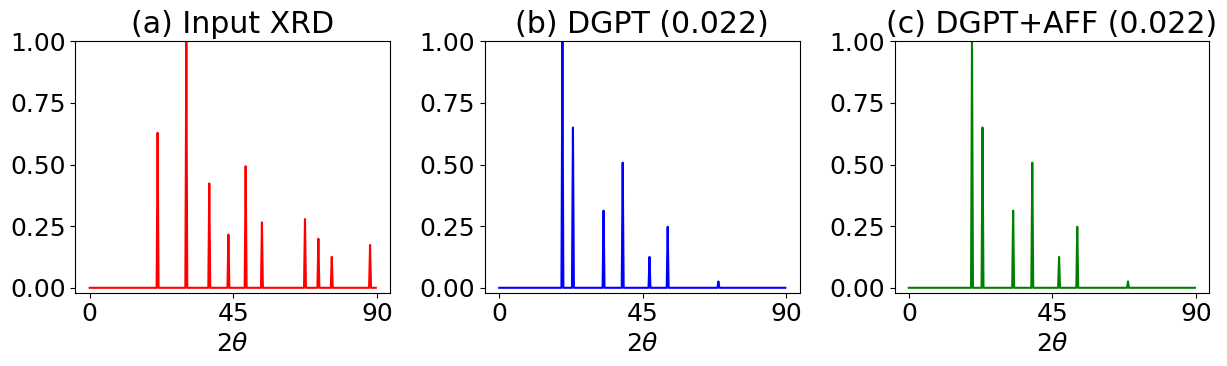

In [19]:
%%time
# https://www.ctcms.nist.gov/~knc6/static/JARVIS-DFT/JVASP-19821.xml
from jarvis.io.vasp.inputs import Poscar
pos="""LaB6
1.0
4.154998579020728 0.0 0.0
0.0 4.154998579020728 -0.0
0.0 0.0 4.154998579020728
La B
1 6
Cartesian
0.0 0.0 0.0
3.3248945674454897 2.0775 2.0775
0.8301054325545105 2.0775 2.0775
2.0775 2.0775 3.3248945674454897
2.0775 2.0775 0.8301054325545105
2.0775 0.8301054325545105 2.0775
2.0775 3.3248945674454897 2.0775
"""
atoms=Poscar.from_string(pos).atoms
y_new_str,cccc = smooth_xrd(atoms=atoms,intvl=0.3,thetas=[0,90])
main_spectra(model=model,spectra=[[y_new_str,cccc]],formulas=["LaB6"],tokenizer=tokenizer,filename=None,calculator=None)

# Inference on experimental XRD pattern from RRUFF

In [12]:
!wget https://rruff.info/index.php/r=file_download/file_type=rruff/table=sample_child_record_powder/sample_id=575/file_id=4415 -O Si.xy

--2025-02-01 13:52:34--  https://rruff.info/index.php/r=file_download/file_type=rruff/table=sample_child_record_powder/sample_id=575/file_id=4415
Resolving rruff.info (rruff.info)... 128.196.236.195
Connecting to rruff.info (rruff.info)|128.196.236.195|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://rruff.info/tmp_rruff/Silicon__R050145-1__Powder__Xray_Data_XY_Processed__4415.rruff [following]
--2025-02-01 13:52:43--  https://rruff.info/tmp_rruff/Silicon__R050145-1__Powder__Xray_Data_XY_Processed__4415.rruff
Reusing existing connection to rruff.info:443.
HTTP request sent, awaiting response... 200 OK
Length: 171669 (168K)
Saving to: ‘Si.xy’

Si.xy               100%[===================>] 167.65K   280KB/s    in 0.6s    

2025-02-01 13:52:44 (280 KB/s) - ‘Si.xy’ saved [171669/171669]



In [16]:
def main_spectra_exp(
    spectra=[],
    formulas=[],
    model=None,
    process_input=False,
    tokenizer=None,
    calculator=None,
    device="cpu",
    max_new_tokens=1000,
    intvl=0.3,
    thetas=[0, 90],
    filename=None,
    panels=[
        "a",
        "b",
        "c",
        "d",
        "e",
        "f",
        "g",
        "h",
        "i",
        "j",
        "k",
        "l",
        "m",
        "n",
        "o",
        "p",
        "q",
        "r",
        "s",
        "t",
        "u",
        "v",
        "w",
        "x",
        "y",
        "z",
    ],
    fmax=0.05,
    nsteps=150,
):
    the_grid = GridSpec(len(spectra), 4)
    plt.rcParams.update({"font.size": 18})
    plt.figure(figsize=(16, 4 * len(spectra)))
    count = 0
    for ii, spec in enumerate(spectra):
       try:
        plt.subplot(the_grid[ii, 1])
        # y_new_str=, cccc = smooth_xrd(atoms=atoms1, intvl=intvl, thetas=thetas)
        # plt.plot(cccc,label='Target')
        # targ = cccc
        spec = np.array(spec)
        spec = spec / np.max(spec)
        y_new_str = "\n".join(["{0:.2f}".format(x) for x in spec])
        # atoms1 = Atoms.from_dict(
        #     get_jid_data(jid=filename, dataset="dft_3d")["atoms"]
        # )
        # y_new_str,cccc = smooth_xrd(atoms=atoms1,intvl=0.3)
        title = "(" + panels[count] + ") " + "Input XRD"
        count += 1
        plt.title(title)

        plt.plot(spec, c="red")
        plt.ylim([-0.02, 1.01])
        plt.xticks([0, 150, 300], [0, 45, 90])
        plt.xlabel(r"$2\theta$")
        plt.tight_layout()
        # plt.legend()

        # import sys
        # sys.exit()
        # x, d_hkls1, y = XRD().simulate(atoms=atoms1)
        formula = formulas[ii]  # atoms1.composition.reduced_formula
        # intvl=0.3
        # x, y_corrected = processed(x=x, y=y,intvl=intvl)
        # y_corrected=y
        # two_thetas = np.array(x)  # two_thetas)
        # intensities = np.array(y_corrected)
        # print('intensities',list(intensities))
        # y_new_str = "\n".join(["{0:.3f}".format(x) for x in y_corrected])
        # y_new_str = "\n".join(["{0:.2f}".format(x) for x in y_corrected])
        # y_new_str, cccc = smooth_xrd(atoms=atoms1, intvl=intvl, thetas=thetas)
        info = {}
        info["instruction"] = "Below is a description of a material."
        info["input"] = (
            "The chemical formula is "
            + formula
            # + " The  "
            + " The  "
            + "XRD"
            # "The chemical elements are "
            # + Composition.from_string(formula).search_string
            + " is "
            + y_new_str
            + "."
            + " Generate atomic structure description with lattice lengths, angles, coordinates and atom types."
        )
        # print(info)
        atoms = gen_atoms(
            prompt=info["input"],
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=max_new_tokens,
        )
        print(atoms)
        plt.subplot(the_grid[ii, 0])
        # atoms1 = get_atoms(jid)
        # formula=atoms1.composition.reduced_formula
        # view(atoms1.make_supercell([2,2,2]).ase_converter(),viewer='x3d')
        plot_atoms(
            atoms.make_supercell(
            #atoms.get_conventional_atoms.make_supercell(
                [1, 1, 1]
            ).ase_converter(),
            plt.subplot(the_grid[ii, 0]),
            radii=0.5,
            rotation=("45x,45y,0z"),
        )
        title = (
            "(" + panels[count] + ") " + formula
        )  # atoms1.composition.reduced_formula
        count += 1
        plt.title(title)
        plt.axis("off")

        plt.subplot(the_grid[ii, 2])
        y_new_str, cccc = smooth_xrd(atoms=atoms, intvl=intvl, thetas=thetas)
        # x, d_hkls1, y = XRD().simulate(atoms=optim)
        # y=np.array(y)/max(y)
        # plt.bar(x,y,label='DiffractGPT+ALIGNN-FF')
        # mae=round(stats.pearsonr(targ, cccc)[0], 2) #
        mae = round(mean_absolute_error(spec, cccc), 3)
        # plt.title('DiffractGPT'+str(mae))
        plt.plot(cccc, c="blue")
        plt.xticks([0, 150, 300], [0, 45, 90])
        plt.ylim([-0.02, 1])

        plt.xlabel(r"$2\theta$")
        plt.tight_layout()
        title = "(" + panels[count] + ") " + "DGPT" + " (" + str(mae) + ")"
        count += 1
        plt.title(title)
        # plt.legend()
        # optim=atoms
        optim = relax_atoms(
            atoms=atoms, calculator=calculator, fmax=fmax, nsteps=nsteps
        )
        print(optim)
        # x, d_hkls1, y = XRD().simulate(atoms=atoms1)
        # y=np.array(y)/max(y)
        # plt.bar(x,y,label='Target')

        plt.subplot(the_grid[ii, 3])
        y_new_str, cccc = smooth_xrd(atoms=optim, intvl=intvl, thetas=thetas)
        # x, d_hkls1, y = XRD().simulate(atoms=optim)
        # y=np.array(y)/max(y)
        # plt.bar(x,y,label='DiffractGPT+ALIGNN-FF')
        # mae=round(stats.pearsonr(targ, cccc)[0], 2)
        mae = round(mean_absolute_error(spec, cccc), 3)
        # plt.title('DiffractGPT-A'+str(mae))
        plt.plot(cccc, c="green")
        plt.xticks([0, 150, 300], [0, 45, 90])
        plt.xlabel(r"$2\theta$")
        plt.ylim([-0.02, 1])

        title = "(" + panels[count] + ") " + "DGPT+AFF" + " (" + str(mae) + ")"
        count += 1
        plt.title(title)
        plt.tight_layout()
       except Exception as exp :
           print('failed for',ii)
           pass
    if filename is not None:
        plt.savefig(filename)
        plt.close()
    # plt.xlim([0,90])
    # plt.legend()



response 
4.18 4.18 4.18
109 109 109
Si 0.000 0.000 0.000
Si 0.250 0.750 0.500
Si 0.750 0.500 0.250
Si 0.500 0.250 0.750
System
1.0
3.95227 0.0 -1.36087
-1.90788 3.46128 -1.36087
0.0 0.0 4.18
Si 
4 
direct
0.0 0.0 0.0 Si
0.25 0.75 0.5 Si
0.75 0.5 0.25 Si
0.5 0.25 0.75 Si

System
1.0
3.95227 0.0 -1.36087
-1.90788 3.46128 -1.36087
0.0 0.0 4.18
Si 
4 
direct
0.0 0.0 0.0 Si
0.25 0.75 0.5 Si
0.75 0.5 0.25 Si
0.5 0.25 0.75 Si



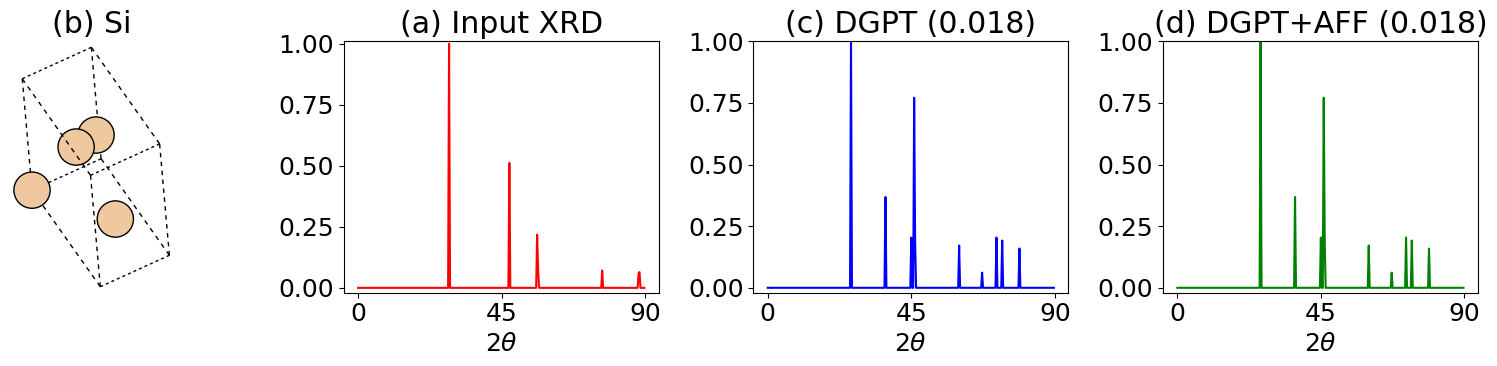

In [18]:
def load_exp_file(filename="", intvl=0.3,separator=","):
    # df = pd.read_csv(
    #     filename,
    #     skiprows=1,
    #     sep=" ",
    #     engine="python",
    # )
    #df=pd.read_csv(filename,skiprows=1,sep=separator,names=["X","Y"],comment="#",)
    df=pd.read_csv(filename,sep=separator,names=["X","Y"],comment="#",)
    if ".txt" in filename:

        with open(filename, "r") as f:
            lines = f.read().splitlines()
        for i in lines:
            if "##IDEAL CHEMISTRY=" in i:
                formula = Composition.from_string(
                    i.split("##IDEAL CHEMISTRY=")[1]
                    .replace("_", "")
                    .replace("^", "")
                    .replace("+", "")
                ).reduced_formula

                tmp = (
                    i.split("##IDEAL CHEMISTRY=")[1]
                    .replace("_", "")
                    .split("&#")[0]
                )
                formula = parse_formula(tmp)
                print("formula",formula, i)

    else:
        formula = filename.split("_")[0]
    # x = df["X"].values
    # y = df["Y"].values
    x=np.array(df.X.values,dtype='float')
    y=np.array(df.Y.values,dtype='float')
    y=y/np.max(y)
    # if df["Z"].isnull()[0]:
    #     y = df["Y"].values
    # else:
    #     y = df["Z"].values
    # y=np.array(y)
    # y=y/np.max(y)
    x, y_corrected = processed(x=x, y=y, intvl=intvl,background_subs=True)
    return formula, x, y_corrected



formulas=[]
spectra=[]
filename='Si.xy'
formula, x, y = load_exp_file(filename=filename, intvl=0.3)
y[y<0.05]=0
formulas.append("Si")
spectra.append(y)

main_spectra_exp(
    model=model,
    tokenizer=tokenizer,
    filename=None,
    # panels=[str(j) for j in np.arange(100)],
    calculator=None,
    device=device,
    spectra=spectra,
    formulas=formulas,
)

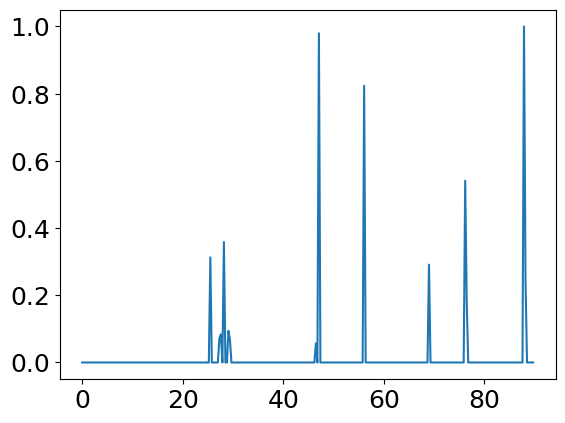

In [27]:
plt.plot(x,y)